In [42]:
import os
import sys

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import plotly
import plotly.graph_objs as go
import plotly.express as px

from scipy.stats import moment, skew, kurtosis

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import RidgeClassifierCV
from sklearn.ensemble import RandomForestClassifier

from catboost import CatBoostClassifier

from joblib import dump, load

У нас перших 3 строчки файлу це даны про час, налаштування програми та датчик. Щоб правильно зчитати файл скіпнемо їх.

In [3]:
def skip_fun(x):
    return x in (0, 1, 2)

In [3]:
data = pd.read_csv("1.txt", skiprows=skip_fun)

In [4]:
data

,Time (s),X (m/s2),Y (m/s2),Z (m/s2),R (m/s2),Theta (deg),Phi (deg)
0,0.000000,-0.595281,0.607619,9.569375,9.607106,5.079640,134.412399
1,0.019914,-0.207210,0.569291,9.715501,9.734371,3.568151,110.000504
2,0.039813,-0.398851,0.528567,9.753829,9.776279,3.883730,127.037781
3,0.059726,-0.449156,0.456702,9.842463,9.863285,3.723679,134.522720
4,0.079680,-0.324590,0.463888,9.945469,9.961572,3.258225,124.981079
...,...,...,...,...,...,...,...
4060,80.844734,-4.099898,-1.893283,9.001642,10.070911,26.641977,204.786926
4061,80.864647,-4.028033,-1.847769,9.066320,10.091455,26.049417,204.642227
4062,80.884560,-3.932213,-1.816628,9.078298,10.058723,25.507387,204.796280
4063,80.904480,-4.037615,-1.833396,9.011224,10.043199,26.201551,204.421799


Наш датасет це дані з аксел та гірос з телефона закріпленого на запясті, під час розминки перед тренуванням.
Виконуємо 3 вправи по 15 сек, між ними відпочиваємо по 10 сек.

In [5]:
data.rename(columns={"Time (s)": "Time",
                     " X (m/s2)": "X",
                     " Y (m/s2)": "Y",
                     " Z (m/s2)": "Z",
                     " R (m/s2)": "R",
                     " Theta (deg)": "Theta",
                     " Phi (deg)": "Phi",}, inplace=True)

In [7]:
data["frec"] = 1 / data["Time"].diff()

Намалюємо наші дані для первиного аналізу.

In [8]:
data

,Time,X,Y,Z,R,Theta,Phi,frec
0,0.000000,-0.595281,0.607619,9.569375,9.607106,5.079640,134.412399,NaN
1,0.019914,-0.207210,0.569291,9.715501,9.734371,3.568151,110.000504,50.216937
2,0.039813,-0.398851,0.528567,9.753829,9.776279,3.883730,127.037781,50.253529
3,0.059726,-0.449156,0.456702,9.842463,9.863285,3.723679,134.522720,50.216685
4,0.079680,-0.324590,0.463888,9.945469,9.961572,3.258225,124.981079,50.117274
...,...,...,...,...,...,...,...,...
4060,80.844734,-4.099898,-1.893283,9.001642,10.070911,26.641977,204.786926,50.257570
4061,80.864647,-4.028033,-1.847769,9.066320,10.091455,26.049417,204.642227,50.219207
4062,80.884560,-3.932213,-1.816628,9.078298,10.058723,25.507387,204.796280,50.219207
4063,80.904480,-4.037615,-1.833396,9.011224,10.043199,26.201551,204.421799,50.199795


In [9]:
trace0 = go.Scatter(x=data["Time"], y=data["frec"], name="frec")
trace1 = go.Scatter(x=data["Time"], y=data["X"], name="acc_X")
trace2 = go.Scatter(x=data["Time"], y=data["Y"], name="acc_Y")
trace3 = go.Scatter(x=data["Time"], y=data["Z"], name="acc_Z")
trace4 = go.Scatter(x=data["Time"], y=data["R"], name="acc_full")
trace5 = go.Scatter(x=data["Time"], y=data["Theta"], name="Theta")
trace6 = go.Scatter(x=data["Time"], y=data["Phi"], name="Phi")


data2 = [trace0, trace1, trace2, trace3, trace4, trace5, trace6]
layout = {"title": "Залежність прискорення (частоти) датчика від часу"}

fig = go.Figure(data=data2, layout=layout).update_layout(xaxis_title="Час (номер точки)",
                                                         yaxis_title="Прискорення (або частота чи кут)",
                                                         template='plotly')

plotly.offline.plot(fig, filename="fit_full_graph_1.html", show_link=False);

In [11]:
for i in range(2, 6):
    data_i = pd.read_csv(str(i) + ".txt", skiprows=skip_fun)

    data_i.rename(columns={"Time (s)": "Time",
                         " X (m/s2)": "X",
                         " Y (m/s2)": "Y",
                         " Z (m/s2)": "Z",
                         " R (m/s2)": "R",
                         " Theta (deg)": "Theta",
                         " Phi (deg)": "Phi", }, inplace=True)
    data_i["frec"] = 1 / data_i["Time"].diff()

    trace0 = go.Scatter(x=data_i["Time"], y=data_i["frec"], name="frec")
    trace1 = go.Scatter(x=data_i["Time"], y=data_i["X"], name="acc_X")
    trace2 = go.Scatter(x=data_i["Time"], y=data_i["Y"], name="acc_Y")
    trace3 = go.Scatter(x=data_i["Time"], y=data_i["Z"], name="acc_Z")
    trace4 = go.Scatter(x=data_i["Time"], y=data_i["R"], name="acc_full")
    trace5 = go.Scatter(x=data_i["Time"], y=data_i["Theta"], name="Theta")
    trace6 = go.Scatter(x=data_i["Time"], y=data_i["Phi"], name="Phi")


    data2 = [trace0, trace1, trace2, trace3, trace4, trace5, trace6]
    layout = {"title": "Залежність прискорення (частоти) датчика від часу (file " + str(i) + ")"}

    fig = go.Figure(data=data2, layout=layout).update_layout(xaxis_title="Час (номер точки)",
                                                             yaxis_title="Прискорення (або частота чи кут)",
                                                             template='plotly')

    plotly.offline.plot(fig, filename="fit_full_graph_" + str(i) + ".html", show_link=False);

С даними, як і очікувалось після минулого разу, все добре, немає недоліків, щодо позитивних частин дивись минулу презентацію. Також цікавим є факт того, що максимальні значення прискорень не вишли за ліміт нашего датчика, але наблизились до нього, з цим потрібно бути обережним.
Також можно помітити активності в зоні відпочинку, ми продовжуємо руху руками, що може ускладнити розбиття на окремі сигнали.
Також сигнали з деяких колонок дуже корелюють, можливо нам не потрібні деякі з них.

<AxesSubplot:>

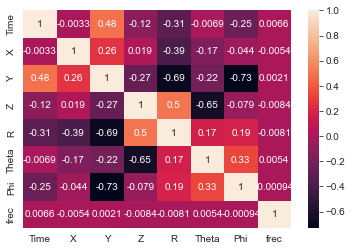

In [12]:
sns.heatmap(data.corr(), annot=True)

А ні, мені просто здалось, поки працюємо з усіма даними.

Ок, тепер треба трошки відфільтрувати дані, будемо використовувати медіанний фільтр, бо швидко та гарно, якщо не буде працювати глянемо на Фурьє та інші. Виходячи з характерних частот наших рухів та шумів, вікно буде в діапазоні 4 - 8 точок, а далі виберу на око(
Мені сподобалось 5)

In [26]:
data_filt = data.drop("frec", axis=1)

for i in ["X", "Y", "Z", "R", "Theta", "Phi"]:
    data_filt[i] = data_filt[[i]].rolling(5).mean()
    data_filt.loc[range(4), [i]] = data.loc[range(4), [i]]

In [25]:
trace1 = go.Scatter(x=data_filt["Time"], y=data_filt["X"], name="acc_X")
trace2 = go.Scatter(x=data_filt["Time"], y=data_filt["Y"], name="acc_Y")
trace3 = go.Scatter(x=data_filt["Time"], y=data_filt["Z"], name="acc_Z")
trace4 = go.Scatter(x=data_filt["Time"], y=data_filt["R"], name="acc_full")
trace5 = go.Scatter(x=data_filt["Time"], y=data_filt["Theta"], name="Theta")
trace6 = go.Scatter(x=data_filt["Time"], y=data_filt["Phi"], name="Phi")


data2 = [trace1, trace2, trace3, trace4, trace5, trace6]
layout = {"title": "Залежність прискорення від часу (filt)"}

fig = go.Figure(data=data2, layout=layout).update_layout(xaxis_title="Час (номер точки)",
                                                         yaxis_title="Прискорення (або частота чи кут)",
                                                         template='plotly')

plotly.offline.plot(fig, filename="fit_full_filt_graph_1.html", show_link=False);

Я пробував розділювати данні на сигнали за допомогою AffPro навченому на старому дата сеті, як і минулого разу, але тут він відпрацьовує погано, все-таки дуже різні типи активності. Тому придумаємо якісь евристики для розподілу.
ОК, Я придумав,так як у нас є зони відпочинку між нашими вправами,то будемо їх шукати. В мене є декілька ідей, рухи під час відпочинку є у діапазоні 7 -- 13, тому будемо йти вікном в 0.5 сек = 25 точок, та дивитися на мінімальне та максимальне значення повного прискорення в вікні.

In [35]:
data_filt["win_ind"] = data_filt.index // 25

In [44]:
data_win_25 = data_filt.loc[:, ["R", "win_ind"]]\
    .groupby("win_ind")\
    .aggregate(lambda x: int((x.max() > 15) or (x.min() < 6)))\
    .rename(columns={"R": "Active"})\
    .reset_index()

In [46]:
data_filt = pd.merge(data_filt, data_win_25, how='outer', on='win_ind')

In [47]:
data_filt

,Time,X,Y,Z,R,Theta,Phi,win_ind,Active
0,0.000000,-0.595281,0.607619,9.569375,9.607106,5.079640,134.412399,0,0
1,0.019914,-0.207210,0.569291,9.715501,9.734371,3.568151,110.000504,0,0
2,0.039813,-0.398851,0.528567,9.753829,9.776279,3.883730,127.037781,0,0
3,0.059726,-0.449156,0.456702,9.842463,9.863285,3.723679,134.522720,0,0
4,0.079680,-0.395018,0.525213,9.765327,9.788523,3.902685,126.190897,0,0
...,...,...,...,...,...,...,...,...,...
4060,80.844734,-4.186615,-1.964669,9.110398,10.217471,26.910146,205.138663,162,0
4061,80.864647,-4.164097,-1.949817,9.110877,10.206046,26.773685,205.087070,162,0
4062,80.884560,-4.076901,-1.908615,9.102253,10.155051,26.310668,205.077139,162,0
4063,80.904480,-4.032345,-1.865017,9.055301,10.086699,26.133790,204.819324,162,0


In [48]:
fig = px.scatter(x=data_filt["Time"],
                 y=data_filt["R"],
                 color=data_filt["Active"])\
         .update_layout(title="Залежність повного прискорення від часу (filt + Active)",
                        xaxis_title="Час",
                        yaxis_title="Прискорення",
                        template='plotly')

plotly.offline.plot(fig, filename="fit_R_filt_active_graph_1.html", show_link=False);

ОК тепер коли побачили, що працює розкатимо на всі файли.

Зробимо перевірку даних на основні параметри нашого сигналу, які можуть показувати, що з датчиком чи самим сигналом, щось не так, та якщо є проблеми запишемо звіт помилок.
 На жаль я сходу не зміг придумати багато автоматичних перевірок, які б мали би сенс, але потім можно дописати ще, головне структура.
1) Перевірка стабільності частот
2) У нас є обмеження на макс. прискорення по 1 осі, це 8g перевіримо його.
3) У всіх моїх рухах мені не вдалось розігнатися вище 12g, тому пускай вище 15 це аномалія.
4) В мене був баг з стабільністю запису, залишалась лише перша та остання секунда, перевіримо довжину сигналу.
5) Средне значення повного прискорення повинне бути рівне g, це з точки зору логіки та фізики, але в мене з датчиком щось не так (на датчиках інших телефонів все було норм і там би можно було встановити поріг на 0.7g - 1.3g), тому поріг 0.5 - 2g.

In [4]:
def data_is_cor(df, file_name_in):
    df["frec"] = 1 / df["Time (s)"].diff()

    errors = []

    if any(df["frec"].apply(lambda x: np.abs(x - df["frec"].mean()) > 4)):
        errors.append("Не стабільна частота")

    if ((df.loc[:, [" X (m/s2)", ' Y (m/s2)', " Z (m/s2)"]].max()).max() > 80) |\
            ((df.loc[:, [" X (m/s2)", ' Y (m/s2)', " Z (m/s2)"]].min()).min() < -80):
        errors.append("Досягнут ліміт датчика по одній осі")

    if df[" R (m/s2)"].max() > 150:
        errors.append("Аномальні прискорення")

    if df.shape[0] < 300:
        errors.append("Можливо ваш запис був пошкоджений, він надто короткий")

    if not (5 < df[" R (m/s2)"].mean() < 20):
        errors.append("Аномальне середнє прискорення")

    if errors:
        file_report_error = open("Error report train/Error report {}".format(file_name_in), "w")

        original_stdout = sys.stdout
        sys.stdout = file_report_error

        print("Звіт помилок {}".format(file_name_in[:-4]), "", sep="\n")

        errors = "\n".join(errors)
        print("У вашому файлі наявні такі помолки:", "", errors, sep="\n")

        sys.stdout = original_stdout
        file_report_error.close()

        return False
    else:
        return True

In [5]:
data = pd.DataFrame()
i = 0
for file_name in os.listdir("train_file"):
# for file_name in ["Accelerometer Data 2022-08-23 20-37-56.txt"]:
    data_i = pd.read_csv("train_file/" + file_name, skiprows=skip_fun)
    if data_is_cor(data_i, file_name):
        data_i["file_ind"] = i
        data = pd.concat([data, data_i], ignore_index=True)
        i += 1
data.rename(columns={"Time (s)": "Time",
                     " X (m/s2)": "X",
                     " Y (m/s2)": "Y",
                     " Z (m/s2)": "Z",
                     " R (m/s2)": "R",
                     " Theta (deg)": "Theta",
                     " Phi (deg)": "Phi",}, inplace=True)

data.sort_values(by=["file_ind", "Time"], inplace=True)

Чогось воно неправильно компанує файли, тому я ввів сортування.

In [6]:
data

,Time,X,Y,Z,R,Theta,Phi,frec,file_ind
0,0.000000,-0.595281,0.607619,9.569375,9.607106,5.079640,134.412399,NaN,0
1,0.019914,-0.207210,0.569291,9.715501,9.734371,3.568151,110.000504,50.216937,0
2,0.039813,-0.398851,0.528567,9.753829,9.776279,3.883730,127.037781,50.253529,0
3,0.059726,-0.449156,0.456702,9.842463,9.863285,3.723679,134.522720,50.216685,0
4,0.079680,-0.324590,0.463888,9.945469,9.961572,3.258225,124.981079,50.117274,0
...,...,...,...,...,...,...,...,...,...
107974,67.932266,-0.397508,1.945365,9.544670,9.749010,11.751566,101.548599,50.548451,28
107975,67.951988,-0.337687,1.911865,9.499207,9.695576,11.551096,100.016670,50.704797,28
107976,67.971771,-0.277567,1.897508,9.561420,9.751838,11.341144,98.322197,50.548451,28
107977,67.991508,-0.335294,1.899901,9.556635,9.749427,11.413283,100.008492,50.665491,28


In [7]:
data_filt = data.copy()

for i in ["X", "Y", "Z", "R", "Theta", "Phi"]:
    data_filt[i] = data_filt[[i]].rolling(5).mean()
    data_filt.loc[range(4), [i]] = data.loc[range(4), [i]]

In [8]:
data_filt["win_ind"] = data_filt.index // 25

data_win_25 = data_filt.loc[:, ["R", "win_ind"]]\
    .groupby("win_ind")\
    .aggregate(lambda x: int((x.max() > 13) or (x.min() < 7)))\
    .rename(columns={"R": "Active"})\
    .reset_index()

data_filt = pd.merge(data_filt, data_win_25, how='outer', on='win_ind')

In [136]:
data_filt

,Time,X,Y,Z,R,Theta,Phi,file_ind,win_ind,Active
0,0.000000,-0.595281,0.607619,9.569375,9.607106,5.079640,134.412399,1,0,0
1,0.019914,-0.207210,0.569291,9.715501,9.734371,3.568151,110.000504,1,0,0
2,0.039813,-0.398851,0.528567,9.753829,9.776279,3.883730,127.037781,1,0,0
3,0.059726,-0.449156,0.456702,9.842463,9.863285,3.723679,134.522720,1,0,0
4,0.079680,-0.395018,0.525213,9.765327,9.788523,3.902685,126.190897,1,0,0
...,...,...,...,...,...,...,...,...,...,...
37566,75.943588,-0.385436,1.071866,9.907141,9.977228,6.786954,109.300607,10,1502,0
37567,75.963501,-0.377770,1.034018,9.850128,9.916646,6.604150,109.768500,10,1502,0
37568,75.983429,-0.405558,0.969339,9.785928,9.846648,6.272740,111.645392,10,1502,0
37569,76.003342,-0.401246,0.888850,9.741851,9.794607,5.831993,111.987509,10,1502,0


In [32]:
fig = px.scatter(x=data_filt.index,
                 y=data_filt["R"],
                 color=data_filt["Active"])\
    .update_layout(title="Залежність повного прискорення від часу (filt + Active)",
                   xaxis_title="Номер точки(час)",
                   yaxis_title="Прискорення",
                   template='plotly')

plotly.offline.plot(fig, filename="fit_R_filt_active_graph_full.html", show_link=False);

Як ми бачимо досить гарно виділило сигнали, нажаль в деяких місцях побило і зони спокою, але це не страшно, просто плюс роботи на розмітці й це не як не вплине на алгоритм.

In [9]:
data_filt["action_index"] = 0
action_ind = 0
for i in range(1, data_filt.shape[0]):
    if data_filt.loc[i, "Active"] != data_filt.loc[i - 1, "Active"]:
        action_ind += 1
    data_filt.loc[i, "action_index"] = action_ind

In [10]:
fig = px.scatter(x=data_filt.index,
                 y=data_filt["R"],
                 color=data_filt["action_index"])\
    .update_layout(title="Залежність повного прискорення від часу (filt + action)",
                   xaxis_title="Номер точки(час)",
                   yaxis_title="Прискорення",
                   template='plotly')

plotly.offline.plot(fig, filename="fit_R_filt_action_graph_full.html", show_link=False);

Час лейбувати дані:
0 - спокій
1 - Розминка рук
2 - Присідання
3 - Удари

Можно було би зробити більш красиво та акуратно, через создання масивів індексів для окремих дій і за раз все присвоїти, але так я путався в діях.

In [11]:
data_filt["real_action"] = 0

data_filt.loc[data_filt["action_index"] == 1, "real_action"] = 1
data_filt.loc[data_filt["action_index"] == 3, "real_action"] = 2
data_filt.loc[data_filt["action_index"] == 5, "real_action"] = 3
data_filt.loc[data_filt["action_index"] == 7, "real_action"] = 1
data_filt.loc[data_filt["action_index"] == 9, "real_action"] = 2
data_filt.loc[data_filt["action_index"] == 13, "real_action"] = 3
data_filt.loc[data_filt["action_index"] == 15, "real_action"] = 1
data_filt.loc[data_filt["action_index"] == 17, "real_action"] = 2
data_filt.loc[data_filt["action_index"] == 19, "real_action"] = 3
data_filt.loc[data_filt["action_index"] == 21, "real_action"] = 1
data_filt.loc[data_filt["action_index"] == 23, "real_action"] = 2
data_filt.loc[data_filt["action_index"] == 25, "real_action"] = 3
data_filt.loc[data_filt["action_index"] == 27, "real_action"] = 1
data_filt.loc[data_filt["action_index"] == 29, "real_action"] = 2
data_filt.loc[data_filt["action_index"] == 31, "real_action"] = 3

data_filt.loc[data_filt["action_index"] == 33, "real_action"] = 1
data_filt.loc[data_filt["action_index"] == 35, "real_action"] = 2
data_filt.loc[data_filt["action_index"] == 36, "real_action"] = 2
data_filt.loc[data_filt["action_index"] == 37, "real_action"] = 2
data_filt.loc[data_filt["action_index"] == 39, "real_action"] = 3
data_filt.loc[data_filt["action_index"] == 41, "real_action"] = 1
data_filt.loc[data_filt["action_index"] == 43, "real_action"] = 2
data_filt.loc[data_filt["action_index"] == 45, "real_action"] = 3
data_filt.loc[data_filt["action_index"] == 47, "real_action"] = 1
data_filt.loc[data_filt["action_index"] == 49, "real_action"] = 2
data_filt.loc[data_filt["action_index"] == 51, "real_action"] = 3
data_filt.loc[data_filt["action_index"] == 53, "real_action"] = 1
data_filt.loc[data_filt["action_index"] == 55, "real_action"] = 2
data_filt.loc[data_filt["action_index"] == 56, "real_action"] = 2
data_filt.loc[data_filt["action_index"] == 57, "real_action"] = 2
data_filt.loc[data_filt["action_index"] == 59, "real_action"] = 3
data_filt.loc[data_filt["action_index"] == 61, "real_action"] = 1
data_filt.loc[data_filt["action_index"] == 63, "real_action"] = 2
data_filt.loc[data_filt["action_index"] == 65, "real_action"] = 3

data_filt.loc[data_filt["action_index"] == 67, "real_action"] = 1
data_filt.loc[data_filt["action_index"] == 69, "real_action"] = 2
data_filt.loc[data_filt["action_index"] == 71, "real_action"] = 3
data_filt.loc[data_filt["action_index"] == 72, "real_action"] = 3
data_filt.loc[data_filt["action_index"] == 73, "real_action"] = 3
data_filt.loc[data_filt["action_index"] == 75, "real_action"] = 1
data_filt.loc[data_filt["action_index"] == 77, "real_action"] = 2
data_filt.loc[data_filt["action_index"] == 79, "real_action"] = 3
data_filt.loc[data_filt["action_index"] == 81, "real_action"] = 1
data_filt.loc[data_filt["action_index"] == 83, "real_action"] = 2
data_filt.loc[data_filt["action_index"] == 85, "real_action"] = 3
data_filt.loc[data_filt["action_index"] == 87, "real_action"] = 1
data_filt.loc[data_filt["action_index"] == 89, "real_action"] = 2
data_filt.loc[data_filt["action_index"] == 91, "real_action"] = 3
data_filt.loc[data_filt["action_index"] == 93, "real_action"] = 1
data_filt.loc[data_filt["action_index"] == 95, "real_action"] = 2
data_filt.loc[data_filt["action_index"] == 97, "real_action"] = 3
data_filt.loc[data_filt["action_index"] == 99, "real_action"] = 1
data_filt.loc[data_filt["action_index"] == 101, "real_action"] = 2
data_filt.loc[data_filt["action_index"] == 102, "real_action"] = 2
data_filt.loc[data_filt["action_index"] == 103, "real_action"] = 2
data_filt.loc[data_filt["action_index"] == 104, "real_action"] = 2
data_filt.loc[data_filt["action_index"] == 105, "real_action"] = 2
data_filt.loc[data_filt["action_index"] == 107, "real_action"] = 3
data_filt.loc[data_filt["action_index"] == 109, "real_action"] = 1
data_filt.loc[data_filt["action_index"] == 110, "real_action"] = 1
data_filt.loc[data_filt["action_index"] == 111, "real_action"] = 1
data_filt.loc[data_filt["action_index"] == 113, "real_action"] = 2
data_filt.loc[data_filt["action_index"] == 115, "real_action"] = 3

data_filt.loc[data_filt["action_index"] == 117, "real_action"] = 1
data_filt.loc[data_filt["action_index"] == 119, "real_action"] = 2
data_filt.loc[data_filt["action_index"] == 121, "real_action"] = 3
data_filt.loc[data_filt["action_index"] == 123, "real_action"] = 1
data_filt.loc[data_filt["action_index"] == 125, "real_action"] = 2
data_filt.loc[data_filt["action_index"] == 127, "real_action"] = 3
data_filt.loc[data_filt["action_index"] == 129, "real_action"] = 1
data_filt.loc[data_filt["action_index"] == 131, "real_action"] = 2
data_filt.loc[data_filt["action_index"] == 133, "real_action"] = 3
data_filt.loc[data_filt["action_index"] == 135, "real_action"] = 1
data_filt.loc[data_filt["action_index"] == 137, "real_action"] = 2
data_filt.loc[data_filt["action_index"] == 138, "real_action"] = 2
data_filt.loc[data_filt["action_index"] == 139, "real_action"] = 2
data_filt.loc[data_filt["action_index"] == 140, "real_action"] = 2
data_filt.loc[data_filt["action_index"] == 141, "real_action"] = 2
data_filt.loc[data_filt["action_index"] == 142, "real_action"] = 2
data_filt.loc[data_filt["action_index"] == 143, "real_action"] = 2
data_filt.loc[data_filt["action_index"] == 144, "real_action"] = 2
data_filt.loc[data_filt["action_index"] == 145, "real_action"] = 2
data_filt.loc[data_filt["action_index"] == 146, "real_action"] = 2
data_filt.loc[data_filt["action_index"] == 147, "real_action"] = 2
data_filt.loc[data_filt["action_index"] == 149, "real_action"] = 3
data_filt.loc[data_filt["action_index"] == 151, "real_action"] = 1
data_filt.loc[data_filt["action_index"] == 153, "real_action"] = 2
data_filt.loc[data_filt["action_index"] == 154, "real_action"] = 2
data_filt.loc[data_filt["action_index"] == 155, "real_action"] = 2
data_filt.loc[data_filt["action_index"] == 156, "real_action"] = 2
data_filt.loc[data_filt["action_index"] == 157, "real_action"] = 2
data_filt.loc[data_filt["action_index"] == 159, "real_action"] = 3
data_filt.loc[data_filt["action_index"] == 161, "real_action"] = 1
data_filt.loc[data_filt["action_index"] == 163, "real_action"] = 2
data_filt.loc[data_filt["action_index"] == 164, "real_action"] = 2
data_filt.loc[data_filt["action_index"] == 165, "real_action"] = 2
data_filt.loc[data_filt["action_index"] == 166, "real_action"] = 2
data_filt.loc[data_filt["action_index"] == 167, "real_action"] = 2
data_filt.loc[data_filt["action_index"] == 169, "real_action"] = 3
data_filt.loc[data_filt["action_index"] == 171, "real_action"] = 1
data_filt.loc[data_filt["action_index"] == 172, "real_action"] = 1
data_filt.loc[data_filt["action_index"] == 173, "real_action"] = 1
data_filt.loc[data_filt["action_index"] == 175, "real_action"] = 2
data_filt.loc[data_filt["action_index"] == 177, "real_action"] = 3

data_filt.loc[data_filt["action_index"] == 179, "real_action"] = 1
data_filt.loc[data_filt["action_index"] == 181, "real_action"] = 2
data_filt.loc[data_filt["action_index"] == 183, "real_action"] = 3
data_filt.loc[data_filt["action_index"] == 185, "real_action"] = 1
data_filt.loc[data_filt["action_index"] == 187, "real_action"] = 2
data_filt.loc[data_filt["action_index"] == 189, "real_action"] = 3
data_filt.loc[data_filt["action_index"] == 191, "real_action"] = 1
data_filt.loc[data_filt["action_index"] == 193, "real_action"] = 2
data_filt.loc[data_filt["action_index"] == 195, "real_action"] = 3
data_filt.loc[data_filt["action_index"] == 197, "real_action"] = 1
data_filt.loc[data_filt["action_index"] == 199, "real_action"] = 2
data_filt.loc[data_filt["action_index"] == 201, "real_action"] = 3
data_filt.loc[data_filt["action_index"] == 205, "real_action"] = 1
data_filt.loc[data_filt["action_index"] == 207, "real_action"] = 2
data_filt.loc[data_filt["action_index"] == 209, "real_action"] = 3

Воу, коли сигнал поділений на окремі дії, лейбувати дані виходить дуже швидко та легко.

In [115]:
fig = px.scatter(x=data_filt.index,
                 y=data_filt["R"],
                 color=data_filt["real_action"])\
    .update_layout(title="Залежність повного прискорення від часу (real action)",
                   xaxis_title="Номер точки(час)",
                   yaxis_title="Прискорення",
                   template='plotly')

plotly.offline.plot(fig, filename="fit_R_real_action.html", show_link=False);

Так тепер потрібно порахувати фічі для кожного імпульсу та створити дата сет для тренування.
В якості фіч для навчання ми будемо використовувати набір статистичних метрик: мін, макс, середне, стат моменти, квантілі і тд. Для кутових даних деякі фічі не мають глузду (у минулі рази вони були зайві), тому не будемо їх рахувати.

Також хотілось би додати декілька частотних фіч,наприклад основної частоти та її долі в сигналі, а токож кількості перетинів сигналу з середнім. Реалізуємо останню (фун n_cross), а до частотних фіч можно буде повернутися пізніше.

In [11]:
data_filt

,Time,X,Y,Z,R,Theta,Phi,file_ind,win_ind,Active,action_index,real_action
0,0.000000,-0.595281,0.607619,9.569375,9.607106,5.079640,134.412399,1,0,0,0,0
1,0.019914,-0.207210,0.569291,9.715501,9.734371,3.568151,110.000504,1,0,0,0,0
2,0.039813,-0.398851,0.528567,9.753829,9.776279,3.883730,127.037781,1,0,0,0,0
3,0.059726,-0.449156,0.456702,9.842463,9.863285,3.723679,134.522720,1,0,0,0,0
4,0.079680,-0.395018,0.525213,9.765327,9.788523,3.902685,126.190897,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
37566,75.943588,-0.385436,1.071866,9.907141,9.977228,6.786954,109.300607,10,1502,0,66,0
37567,75.963501,-0.377770,1.034018,9.850128,9.916646,6.604150,109.768500,10,1502,0,66,0
37568,75.983429,-0.405558,0.969339,9.785928,9.846648,6.272740,111.645392,10,1502,0,66,0
37569,76.003342,-0.401246,0.888850,9.741851,9.794607,5.831993,111.987509,10,1502,0,66,0


In [12]:
def n_cross(x):
    x_del = x - x.mean()
    return (np.diff(np.sign(x_del)) != 0).sum()

In [20]:
tata = pd.Series([1, 3, 1, 3])
print(n_cross(tata))

3


In [13]:
data_feature_acc = data_filt.loc[:, ["X", "Y", "Z", "R", "action_index"]]\
    .groupby("action_index").aggregate([
    lambda x: x.mean(),
    lambda x: x.std(),
    lambda x: x.max(),
    lambda x: x.min(),
    lambda x: x.std() / x.mean(),
    lambda x: np.percentile(x, 25),
    lambda x: np.percentile(x, 50),
    lambda x: np.percentile(x, 75),
    lambda x: moment(x, moment=3),
    lambda x: moment(x, moment=4),
    lambda x: skew(x),
    lambda x: kurtosis(x),
    lambda x: n_cross(x)])

data_feature_acc = data_feature_acc.T.reset_index().T.drop(["level_0", "level_1"])
data_feature_acc = data_feature_acc.apply(lambda x: x.astype(float))

In [14]:
data_feature_cor = data_filt.loc[:, ["Theta", "Phi", "action_index"]]\
    .groupby("action_index").aggregate([
    lambda x: x.mean(),
    lambda x: x.std(),
    lambda x: x.max(),
    lambda x: x.min(),
    lambda x: x.std() / x.mean(),
    lambda x: np.percentile(x, 25),
    lambda x: np.percentile(x, 50),
    lambda x: np.percentile(x, 75)])

data_feature_cor = data_feature_cor.T.reset_index().T.drop(["level_0", "level_1"])
data_feature_cor = data_feature_cor.apply(lambda x: x.astype(float))

In [15]:
data_feature_acc.reset_index(inplace=True)
data_feature_cor.reset_index(inplace=True)
data_feature = pd.merge(data_feature_acc, data_feature_cor, on="action_index")
data_feature.drop("action_index", axis=1, inplace=True)

In [16]:
data_feature

,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,...,6_y,7_y,8_y,9_y,10_y,11_y,12_y,13_y,14_y,15_y
0,-1.132065,0.225411,-0.207210,-1.379568,-0.199115,-1.255721,-1.192719,-1.109356,0.025164,0.019325,...,8.243245,8.525454,145.233652,5.554249,150.925360,110.000504,0.038244,144.512062,146.596765,148.599144
1,-4.049050,8.500878,9.791606,-33.630664,-2.099474,-8.676621,-1.142893,2.150560,-549.170594,15216.308763,...,79.058659,96.709213,262.034373,24.096394,316.716949,103.456973,0.091959,250.043845,266.071129,277.175999
2,-1.294659,0.501115,2.493955,-3.501981,-0.387063,-1.469160,-1.381005,-1.208530,0.352105,1.662641,...,83.121692,83.805412,262.300551,2.951697,284.726611,250.221582,0.011253,261.263727,261.776062,262.779443
3,-5.066322,5.799340,12.120991,-27.477104,-1.144684,-8.597090,-6.212969,-1.088754,79.001987,3838.029642,...,72.160766,82.392462,198.640619,67.786006,284.473416,33.911350,0.341249,173.127518,230.648912,246.872172
4,-2.389564,0.461623,0.842977,-4.693024,-0.193183,-2.524377,-2.435025,-2.346751,0.222134,1.124650,...,79.801010,80.360733,255.669613,2.616806,274.883374,244.746112,0.010235,254.803201,255.341295,255.885238
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206,-1.491092,0.513711,1.488336,-2.299024,-0.344520,-1.766262,-1.617967,-1.419841,0.371776,0.891749,...,42.764000,44.001992,256.903656,4.300709,280.961005,251.391464,0.016741,254.611789,255.869731,257.353463
207,2.490317,2.914248,12.193286,-8.432427,1.170232,1.112902,2.142055,3.704613,2.611459,354.458953,...,33.226567,38.692875,78.538578,58.359836,322.455487,23.149829,0.743072,49.164691,58.731247,76.647411
208,-1.723131,0.301992,-0.560339,-4.282913,-0.175258,-1.863635,-1.741107,-1.619522,-0.034372,0.166116,...,38.467897,39.273546,253.484340,2.639728,264.198181,233.915723,0.010414,252.144575,253.200856,254.257229
209,-0.679511,6.592114,20.478793,-28.328508,-9.701261,-4.674364,-0.438455,2.952608,-43.065887,7857.236266,...,54.255855,71.409820,145.163642,74.005945,342.416363,25.721074,0.509810,86.287236,120.820849,206.052697


ok, на око фічі згенерилисль нормально та ніяких явних аномалій в них не має.
Да, з оптимальним отриманням рядка таргерів не пішло(, але воно працює)))

In [17]:
y = data_filt.loc[:, ["real_action", "action_index"]]\
             .groupby("action_index").aggregate(lambda x: list(set(x))[0]).real_action

In [18]:
y

action_index
0      0
1      1
2      0
3      2
4      0
      ..
206    0
207    2
208    0
209    3
210    0
Name: real_action, Length: 211, dtype: int64

C:\Users\cuner\AppData\Roaming\JetBrains\DataSpell2022.1\projects\workspace\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



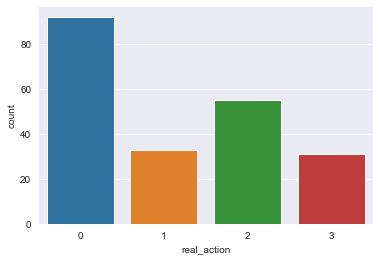

In [19]:
sns.countplot(y);

Розіб'ємо дані на тестову та трейнову частину рандомно, але так щоб був баланс класів в обох виборках, в відношенні 0,8. Параметри моделей де це можливо будемо підбирати на кросвалідації.
В якості оціночної метрики будемо використовувати roc_auc_score (гарна метрика для мультикласової клас з незбалансованими класами)
Також через дисбаланс класів, під час тренування моделей, будемо вводити коефіцієнт, який виправить це.
Що до моделей, які тут можуть підійти, тк як дата сет малий та навчання буде швидким, то я би спробував багато моделей різних класів. (Щось лінійне, KNN, RF, Boosting, SVM) + Плюс найкращі з РСА, бо в минулий раз це покращило результат.
Через деяких модей, одразу відскейлю дані.


In [20]:
Sts = StandardScaler()
data_feature = Sts.fit_transform(data_feature)

C:\Users\cuner\AppData\Roaming\JetBrains\DataSpell2022.1\projects\workspace\venv\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

C:\Users\cuner\AppData\Roaming\JetBrains\DataSpell2022.1\projects\workspace\venv\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.



In [82]:
X_train, X_test, y_train, y_test = train_test_split(data_feature, y,
                                                test_size=0.2, random_state=12, stratify=y)

In [76]:
y_train.reset_index(inplace=True, drop=True)
y_test.reset_index(inplace=True, drop=True)

Почнимо з KNeighborsClassifier. Тут не буду паритись з кросвал, просто підберемо n_neighbors по тесту, бо knn це алгоритм, який просто працює, або не працюю в задачі, в залежності від структури даних

In [39]:
knn_score = []
for i in range(1, 20):
    knn = KNeighborsClassifier(n_neighbors= i, weights="distance").fit(X_train, y_train)
    knn_score.append(roc_auc_score(y_test, knn.predict_proba(X_test), multi_class="ovr"))

In [40]:
knn_score

[0.9535372666540429,
 0.9622883333820834,
 0.959808784027534,
 0.9581064932627432,
 0.9550638808451308,
 0.9543536535724035,
 0.9521621865371865,
 0.9692414614289615,
 0.9675391706641707,
 0.9678942843005343,
 0.9735022156897157,
 0.9754863426738427,
 0.9757806710931711,
 0.9774829618579619,
 0.97535228003978,
 0.9797489250614251,
 0.983005733005733,
 0.983005733005733,
 0.9804591523341524]

Я навчав алгоритм на різних дата сетах ( 1) 10 тільки моїх записів, 2)- 10 + 10 від 2 людей, 3) 20 + 5 від 3 людей), то тут є пункти 1), 2) і тд, для різних дата сетів.
1)Воу, практически все числа от 1 до 9 дают roc = 1, ок пускай будет n_neighbors = 5
2)Воу, практически все числа от 3 до 7 дают roc = 0.99, а для 7 - 20 roc = 0.98 - 0.97, ок пускай будет n_neighbors = 4
3)ok, результат нарешті погіршився до, найкраший результат показує n_neighbors = 16-19, в залезності від сіду roc = 0.95 - 0.99, але якщо глянути на confusion_matrix, то видно що основна проблема в плутанині з присіданнями, я гадаю, що це через помилки на етапі визначення активних та не активних зон,дуже багато маленьких розрізів у присіданнях з поганими показниками, що і сбиває алгоритм.


In [46]:
knn = KNeighborsClassifier(n_neighbors= 18, weights="distance").fit(X_train, y_train)
knn_pred = knn.predict_proba(X_test)
confusion_matrix(y_test, knn.predict(X_test))

array([[18,  0,  0,  1],
       [ 0,  5,  2,  0],
       [ 0,  0,  9,  2],
       [ 1,  0,  0,  5]], dtype=int64)

In [49]:
knn_pred

array([[0.  , 1.  , 0.  , 0.  ],
       [0.  , 0.  , 1.  , 0.  ],
       [1.  , 0.  , 0.  , 0.  ],
       [0.75, 0.  , 0.  , 0.25],
       [0.  , 0.  , 1.  , 0.  ],
       [0.5 , 0.25, 0.25, 0.  ],
       [0.  , 0.  , 0.  , 1.  ],
       [0.  , 0.75, 0.25, 0.  ],
       [0.75, 0.  , 0.  , 0.25],
       [0.  , 0.  , 0.75, 0.25],
       [0.  , 0.  , 1.  , 0.  ],
       [0.  , 0.25, 0.  , 0.75],
       [1.  , 0.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  , 0.  ],
       [0.75, 0.  , 0.25, 0.  ],
       [0.  , 0.  , 0.  , 1.  ],
       [0.  , 1.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 1.  ],
       [0.  , 0.  , 0.  , 1.  ],
       [1.  , 0.  , 0.  , 0.  ]])

In [50]:
y_test

action_index
41     1
103    2
4      0
106    0
101    2
56     2
31     3
67     1
11     0
35     2
3      2
111    1
54     0
6      0
44     0
22     0
24     0
114    0
91     3
87     1
10     0
50     0
73     3
13     3
100    0
Name: real_action, dtype: int64

1)Да, roc 1, явно потрібно більше різних даних.
Давайте спробуємо на різних сідах розбиття трейну, може щось істотно зміниться.
Я змінив 7 рандом сідів і там справи ще краще, схоже что данні з одного мене, на такій малій кількості вправ дуже легкі для алгоритму. Дороблю програму до кінця з усіма фічами, а потім додам даних інших людей та додам вправ.
2) Я додав еще одну людину, і roc ~1, на різних сідах, невже KNN вистрілив.
3) Спробуємо ще декілька алгоритмів, а після цього вже будемо змінювати визначення активних зон

Спробуєм CatBoost, він дуже грано на внутрішніх евристиках пряцює на стандартних налаштуваннях, тому підберемо тільки кількість ітерацій, щоб він не перенавчався.  Я знаю що в нього є така внутрішня функція, але не дивлячись на графіки(в мене слабкий пк) я їй не довіряю.

In [77]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=13)
cat_score_train = []
cat_score_test = []

In [78]:
for n_tree in [20, 50, 100, 150, 200, 130, 170, 220]:
    ctb = CatBoostClassifier(random_seed=17, iterations=n_tree, auto_class_weights="Balanced")
    cv_scores_train = []
    cv_scores_test = []
    for train_idx, test_idx in skf.split(X_train, y_train):
        cv_train_df, cv_valid_df = (X_train[train_idx, :],
                                    X_train[test_idx, :])
        y_cv_train, y_cv_valid = y_train[train_idx], y_train[test_idx]

        ctb.fit(cv_train_df, y_cv_train)

        cv_scores_train.append(roc_auc_score(y_cv_train, ctb.predict_proba(cv_train_df), multi_class="ovr"))
        cv_scores_test.append(roc_auc_score(y_cv_valid, ctb.predict_proba(cv_valid_df), multi_class="ovr"))
    cat_score_train.append(np.mean(cv_scores_train))
    cat_score_test.append(np.mean(cv_scores_test))

Learning rate set to 0.5
0:	learn: 0.9283690	total: 59.4ms	remaining: 1.13s
1:	learn: 0.7478771	total: 114ms	remaining: 1.03s
2:	learn: 0.6062033	total: 168ms	remaining: 952ms
3:	learn: 0.5214983	total: 229ms	remaining: 916ms
4:	learn: 0.4446444	total: 301ms	remaining: 904ms
5:	learn: 0.4010170	total: 379ms	remaining: 885ms
6:	learn: 0.3647375	total: 447ms	remaining: 829ms
7:	learn: 0.3078954	total: 532ms	remaining: 798ms
8:	learn: 0.2667831	total: 605ms	remaining: 740ms
9:	learn: 0.2380030	total: 666ms	remaining: 666ms
10:	learn: 0.2110994	total: 735ms	remaining: 601ms
11:	learn: 0.1892516	total: 830ms	remaining: 554ms
12:	learn: 0.1777175	total: 942ms	remaining: 507ms
13:	learn: 0.1564216	total: 1.02s	remaining: 437ms
14:	learn: 0.1412867	total: 1.09s	remaining: 362ms
15:	learn: 0.1263974	total: 1.15s	remaining: 288ms
16:	learn: 0.1146471	total: 1.22s	remaining: 216ms
17:	learn: 0.1054232	total: 1.28s	remaining: 143ms
18:	learn: 0.0959404	total: 1.35s	remaining: 71.1ms
19:	learn: 0.0

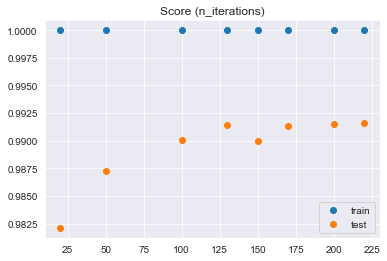

In [79]:
plt.scatter([20, 50, 100, 150, 200, 130, 170, 220],
         cat_score_train, label="train")
plt.scatter([20, 50, 100, 150, 200, 130, 170, 220],
         cat_score_test, label="test")
plt.title("Score (n_iterations)")
plt.legend()
plt.show()

Ну що roc знову 0.99, тому не бачу сесну старатися вибивати більше (цього вистачить для мого проєкту), кількість ітерацій возьмемо трохи с запасом - 180 та розкатимо на повну модель.

In [80]:
ctb = CatBoostClassifier(random_seed=17, iterations=180, auto_class_weights="Balanced").fit(X_train, y_train)

Learning rate set to 0.307687
0:	learn: 1.1109054	total: 66.5ms	remaining: 11.9s
1:	learn: 0.9377597	total: 154ms	remaining: 13.7s
2:	learn: 0.7966766	total: 239ms	remaining: 14.1s
3:	learn: 0.6830340	total: 324ms	remaining: 14.2s
4:	learn: 0.5925896	total: 402ms	remaining: 14.1s
5:	learn: 0.5239895	total: 488ms	remaining: 14.2s
6:	learn: 0.4668469	total: 566ms	remaining: 14s
7:	learn: 0.4026300	total: 644ms	remaining: 13.8s
8:	learn: 0.3710642	total: 728ms	remaining: 13.8s
9:	learn: 0.3327098	total: 817ms	remaining: 13.9s
10:	learn: 0.3081912	total: 906ms	remaining: 13.9s
11:	learn: 0.2907618	total: 987ms	remaining: 13.8s
12:	learn: 0.2690042	total: 1.07s	remaining: 13.8s
13:	learn: 0.2478096	total: 1.16s	remaining: 13.8s
14:	learn: 0.2239166	total: 1.28s	remaining: 14.1s
15:	learn: 0.2078858	total: 1.37s	remaining: 14s
16:	learn: 0.1896479	total: 1.47s	remaining: 14.1s
17:	learn: 0.1800889	total: 1.55s	remaining: 13.9s
18:	learn: 0.1658808	total: 1.63s	remaining: 13.8s
19:	learn: 0.1

In [83]:
ctb_pred = ctb.predict_proba(X_test)
roc_auc_score(y_test, ctb_pred, multi_class="ovr")

0.9963135822510822

ОК, кат буст показав не на багато кращий результат, але тепер він стабыльний до зміни рандом сіда,  тому як модель будемо використовувати його.

Збережимо  найкращі модельки

In [87]:
ctb_full = CatBoostClassifier(random_seed=17, iterations=180, auto_class_weights="Balanced").fit(data_feature, y)

Learning rate set to 0.311284
0:	learn: 1.0421195	total: 167ms	remaining: 29.8s
1:	learn: 0.8525132	total: 287ms	remaining: 25.5s
2:	learn: 0.7206802	total: 375ms	remaining: 22.1s
3:	learn: 0.5961502	total: 889ms	remaining: 39.1s
4:	learn: 0.5116500	total: 1.07s	remaining: 37.6s
5:	learn: 0.4645155	total: 1.76s	remaining: 51s
6:	learn: 0.4135038	total: 1.84s	remaining: 45.5s
7:	learn: 0.3605187	total: 1.93s	remaining: 41.6s
8:	learn: 0.3249003	total: 2.04s	remaining: 38.7s
9:	learn: 0.2990838	total: 2.13s	remaining: 36.3s
10:	learn: 0.2745265	total: 2.22s	remaining: 34.1s
11:	learn: 0.2527306	total: 2.4s	remaining: 33.5s
12:	learn: 0.2310956	total: 2.49s	remaining: 32s
13:	learn: 0.2158991	total: 2.8s	remaining: 33.2s
14:	learn: 0.2024809	total: 2.88s	remaining: 31.7s
15:	learn: 0.1871730	total: 2.96s	remaining: 30.4s
16:	learn: 0.1766520	total: 3.05s	remaining: 29.2s
17:	learn: 0.1638522	total: 3.13s	remaining: 28.2s
18:	learn: 0.1522421	total: 3.21s	remaining: 27.2s
19:	learn: 0.1428

In [89]:
dump(ctb_full, "cat_model_28.joblib")
dump(Sts, "sts_model_28.joblib")

['sts_model_28.joblib']

In [70]:
knn_full = KNeighborsClassifier(n_neighbors= 4).fit(data_feature, y)
dump(knn_full, "knn_model_17.joblib")
dump(Sts, "sts_model_17.joblib")